# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [1]:
# libraries
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils
import BAAnet
import DecoderModule

### Process Endovis 2018 Dataset

In [ ]:
# set seed for reprodicibility
def set_seed(seed):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch random seed for CPU
    torch.cuda.manual_seed(seed)  # PyTorch random seed for GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch random seed for all GPUs 
    # Ensure deterministic behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# get dataloaders and display test images
seed = 42
batch_size = 8
reduce_factor = 4 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers,seed)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

# n = 2
# cmap = plt.get_cmap('Paired',12)
# cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
# cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
#                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

# fig, axes = plt.subplots(n, 2, figsize=(20, 20))
# for i in range(n):  # Flatten the 2D array of axes
#     axes[i,0].imshow(images[i].permute(1, 2, 0))  
#     #axes[i,1].imshow(labels[i].permute(1, 2, 0))
#     label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
#     im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
#     # colorbar settings
#     cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
#     cbar.set_label("Segmentation Labels", fontsize=10)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels(cbar_labels)

# plt.tight_layout()
# plt.show()

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (320, 256)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


In [3]:
# DEBUGGING
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
label = labels[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,160]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model = DecoderModule.DecoderModule([24,32,64,64])
img = model(y1,y2,y3,y4)
print()
print("Decoder:", img.shape)


model_BBA = BAAnet.BAANet_BBA_Only()
out = model_BBA(input)
print()
print("BAA_Only:", out.shape)

model_full = BAAnet.BAANet()
out = model_full(input)
print()
print("BAAnet Full:", out.shape)

c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


x0: torch.Size([1, 3, 320, 256])
x1: torch.Size([1, 24, 80, 64])
x2: torch.Size([1, 32, 40, 32])
x3: torch.Size([1, 64, 20, 16])
x4: torch.Size([1, 160, 10, 8])

y1: torch.Size([1, 24, 80, 64])
y2: torch.Size([1, 32, 40, 32])
y3: torch.Size([1, 64, 20, 16])
y4: torch.Size([1, 64, 20, 16])
out3 shape: torch.Size([1, 64, 20, 16])
out2 shape: torch.Size([1, 32, 40, 32])
out1 shape: torch.Size([1, 24, 80, 64])

Decoder: torch.Size([1, 12, 320, 256])

BAA_Only: torch.Size([1, 12, 320, 256])
out3 shape: torch.Size([1, 64, 20, 16])
out2 shape: torch.Size([1, 32, 40, 32])
out1 shape: torch.Size([1, 24, 80, 64])

BAAnet Full: torch.Size([1, 12, 320, 256])


## Create Model and Hyperparameters


In [4]:
# model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 11
lr = 1e-4

set_seed(seed) # set random seed
model = BAAnet.BAANet_BBA_Only().to(device)
#model = BAAnet.BAANet().to(device)
#model = BAAnet.BAANet_BAF_Only().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
#criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) # learning rate scheduler

cuda:0


In [ ]:
# train model. Output is [epoch, training_loss, mdice, miou, mdice_robot, miou_robot]
training_outputs = []

for i in range(epochs):
    training_output = TrainingUtils.train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler, i, device)
    training_outputs.append(training_output)


0it [00:00, ?it/s]c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
205it [04:39,  1.36s/it]
75it [11:02,  8.83s/it]


Epoch 0: Training Loss = 0.9461108912727123, mDICE: 0.6462786084729857, mIoU: 0.6085285365758891 mDICE Robot: 0.6589655117809113, mIoU Robot: 0.5248767996304947


205it [04:20,  1.27s/it]


Epoch 1: Training Loss = 0.9325626612037586, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:22,  1.28s/it]


Epoch 2: Training Loss = 0.9269009958394333, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:29,  1.32s/it]


Epoch 3: Training Loss = 0.9235217323907466, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:28,  1.31s/it]


Epoch 4: Training Loss = 0.9215668740969769, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


92it [01:59,  1.32s/it]

In [ ]:
# save model if necessary
torch.save(model.state_dict(), "model1.pth")

In [ ]:
# load a model if necessary
model = BAAnet.BAANet_BBA_Only().to(device) # change to model you are loading
model.load_state_dict(torch.load("model.pth"))
model.eval()

c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\samee\AppData\Local\Temp\ipykernel_35996\429827041.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

BAANet_BBA_Only(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

Index 0: <class 'int'>
Index 1: <class 'float'>
Index 2: <class 'torch.Tensor'>
Index 3: <class 'torch.Tensor'>
Index 4: <class 'torch.Tensor'>
Index 5: <class 'torch.Tensor'>
[[0.         0.94785132 0.63007975 0.59306316 0.61949999 0.47728334]]


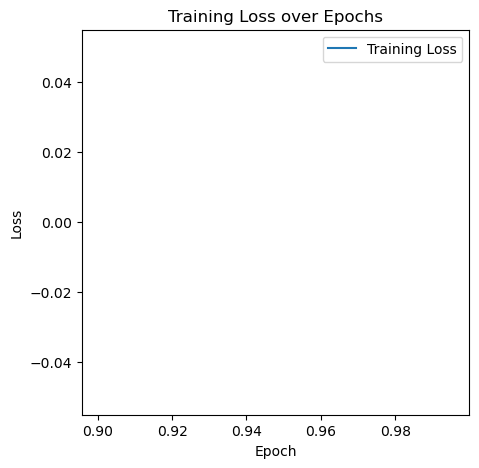

In [ ]:
# plot training loss curve
for idx, item in enumerate(training_outputs[0]):
    print(f"Index {idx}: {type(item)}")
    
training_outputs_cpu = []
for i in training_outputs:
    temp = []
    for j in i:
        if torch.is_tensor(j):
            temp.append(j.cpu())
        else:
            temp.append(j)
    training_outputs_cpu.append(temp)
    
training_outputs_cpu = np.array(training_outputs_cpu)
print(training_outputs_cpu)
    
plt.figure(figsize=(5, 5))
plt.plot(training_outputs_cpu[:,1], training_outputs_cpu[:,0], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# test model
m_dice, m_iou, mdice_robot, miou_robot = TrainingUtils.test(model, test_dataloader, device)
print(f"Mean DICE Score: {m_dice}")
print(f"Mean IoU Score: {m_iou}")
print(f"Mean DICE Robot Score: {mdice_robot}")
print(f"Mean IoU Robot Score: {miou_robot}")

125it [17:34,  8.43s/it]

Mean DICE Score: 0.7223474009200337
Mean IoU Score: 0.6767086305628142
Mean DICE Robot Score: 0.6906215246447882
Mean IoU Robot Score: 0.590147766022007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9887688..2.9536147].


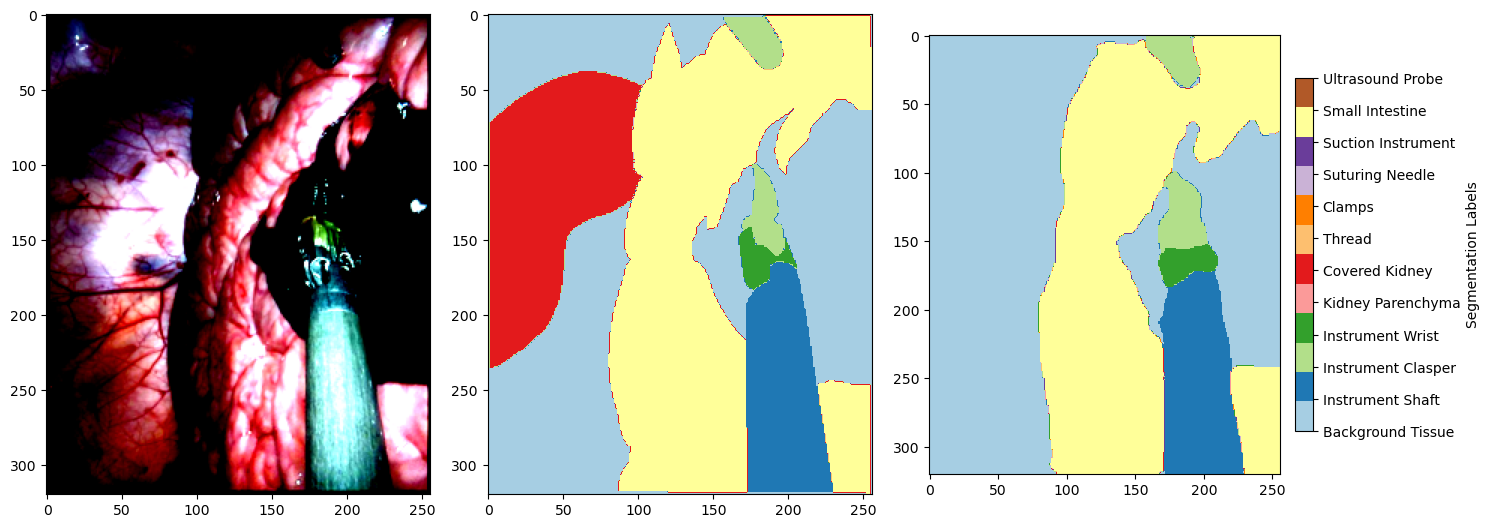

In [ ]:
# display model outputs
model.cpu()
i = 3 # 0 to batch_size
input = images[i:i+1]
label = labels[i:i+1]

predict = model(input) # predict image
predict = torch.argmax(predict, dim=1) # get grayscale prediction
predict = torch.eye(12, device=predict.device)[predict].permute(0,3,1,2)
predict = torch.nn.functional.interpolate(predict.float(), size=label.shape[2:], mode="nearest-exact")  # Match label size
prediction = EndovisDataloader.convert_masks_to_gray(predict.squeeze(0))

label = EndovisDataloader.convert_masks_to_gray(label.squeeze(0))

cmap = plt.get_cmap('Paired',12)
cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
               "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

# un-normalize input
mean=(0.464, 0.341, 0.363).view(-1, 1, 1)
std=(0.210, 0.194, 0.204).view(-1, 1, 1)
input = input.squeeze(0) * std + mean

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
axes[0].imshow(input.permute(1, 2, 0))
axes[1].imshow(label, cmap = cmap, vmin = 0, vmax = 11)
im = axes[2].imshow(prediction, cmap = cmap, vmin = 0, vmax = 11)

cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label("Segmentation Labels", fontsize=10)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_labels)


plt.tight_layout()
plt.show()

# things to record: epochs, batch_size, reduce_factor, training loss curve, training time, validation score curves, test scores, test time, example image (below)